## **Calcul de l'indice de sol nu (Bare Soil Index BI) au Sénégal**

Le Bare Soil Index (BSI) est un indice spectral conçu pour différencier les surfaces minérales (sols nus) de la végétation et des plans d'eau.


La formule utilisée pour son calcul est la suivante :

#  **BSI = [(SWIR1 + R) - (NIR + B)]/[(SWIR1 + R) + (NIR + B)]**

Physiquement, le sol nu se caractérise par une réflectance relativement élevée dans le rouge (R) et le proche infrarouge à ondes courtes (SWIR, S1), liée à la composition minérale et à l’état de sécheresse du sol, tandis qu’il présente une réflectance plus faible dans le bleu (B) et le proche infrarouge (NIR, N), bandes où la végétation réfléchit fortement et l’eau absorbe fortement le rayonnement.

Le BSI exploite cette opposition spectrale en comparant la somme des bandes dominantes du sol nu (S1+R) à celle des bandes associées à la végétation et à l’eau (N+B) en normalisant cette différence.

Ainsi les valeurs positives du BSI indiquent une dominance de sols nus,  secs ou faiblement végétalisés, tandis que les valeurs négatives ou presque nulles traduisent la présence de végétation ou de surfaces humides (car l'eau absorbe presque tout).

L’objectif de cette section est de calculer le Bare Soil Index (BSI) pour chacun des 45 départements du Sénégal à partir des images Sentinel-2 de l’année 2018, puis de fusionner les indicateurs obtenus avec la base de données ménages de l’enquête EHCVM 2018. Cette approche vise à relier un indicateur biophysique issu de la télédétection aux caractéristiques socio-économiques observées à partir de données d'enquêtes.

L’analyse des résultats permettra d’examiner la cohérence spatiale de l’indice en considérant nos connaissances sur la géographie du pays. En particulier, on s’attend à observer des valeurs de BSI relativement plus faibles dans les zones du sud, caractérisées par une couverture végétale plus dense et des conditions climatiques plus humides, et des valeurs plus élevées dans les zones du nord et de l'est, où les sols sont plus secs, plus sableux et la végétation plus clairsemée.

Il convient toutefois de souligner que le BSI, pris isolément, ne permet pas de discriminer parfaitement les sols nus naturels de certaines surfaces artificialisées. En effet, les matériaux de construction tels que le béton ou les surfaces urbaines peuvent présenter des signatures spectrales proches de celles des sols nus, ce qui peut conduire à une surestimation locale de l’indice. Pour cette raison, l’interprétation du BSI doit être réalisée avec prudence et, idéalement, complétée par d’autres indices spectraux ou des informations d’occupation du sol.

### **Step1 : Importation des données**

Nous utilisons les données de la mission spatiale Sentinel-2 du programme européen Copernicus, opérée par l'Agence Spatiale Européenne (ESA).La collection d'images importée depuis GEE est **COPERNICUS/S2_SR_HARMONIZED**. Ce jeu de données correspond au produit Level-2A (Surface Reflectance), garantissant des mesures corrigées des effets atmosphériques. La zone d'étude est délimitée par les frontières administratives du Sénégal via la base de données **GADM 4.1** sur une période temporelle allant du 1er janvier au 31 décembre 2018.

In [ ]:
!pip install earthengine-api geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00


In [26]:
import ee
import geemap


In [27]:
ee.Authenticate()


True

In [28]:
ee.Initialize(project='ee-mamesoda2807')

In [30]:
# Chargement des Assets GADM
departements = ee.FeatureCollection('projects/ee-mamesoda2807/assets/gadm41_SEN_2')
pays = ee.FeatureCollection('projects/ee-mamesoda2807/assets/gadm41_SEN_0')

In [32]:
#Chargement de la collection s2 2018
s2_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(pays)
    .filterDate('2018-01-01', '2018-12-31'))



### **Step 2 : Vérifications**

In [ ]:
#Délimitations du Pays
Map = geemap.Map(center=[14.5, -14.5], zoom=6)
Map.addLayer(pays, {}, "GADM Sénégal (Asset)")
Map

Map(center=[14.5, -14.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# On prend le premier élément pour inspecter ses "clés" (noms de colonnes)
colonnes = departements.first().propertyNames().getInfo()
print("Les colonnes disponibles sont :", colonnes)

Les colonnes disponibles sont : ['ENGTYPE_2', 'NL_NAME_2', 'NL_NAME_1', 'HASC_2', 'NAME_2', 'CC_2', 'NAME_1', 'TYPE_2', 'COUNTRY', 'GID_0', 'GID_1', 'system:index', 'GID_2', 'VARNAME_2']


In [ ]:
liste_noms = departements.aggregate_array('NAME_2').getInfo()
liste_noms.sort()

print(f"Nombre de départements trouvés : {len(liste_noms)}")
print("Liste complète :", liste_noms)

Nombre de départements trouvés : 45
Liste complète : ['Bakel', 'Bambey', 'Bignona', 'Birkilane', 'Bounkiling', 'Dagana', 'Dakar', 'Diourbel', 'Fatick', 'Foundiougne', 'Gossas', 'Goudiry', 'Goudomp', 'Guinguinéo', 'Guédiawaye', 'Kaffrine', 'Kanel', 'Kaolack', 'Kolda', 'Koungheul', 'Koupentoum', 'Kébémer', 'Kédougou', 'Linguère', 'Louga', 'Malème Hodar', 'Matam', 'Mbacké', 'Mbour', 'Médina Yoro Foula', 'Nioro du Rip', 'Oussouye', 'Pikine', 'Podor', 'Ranérou Ferlo', 'Rufisque', 'Saint-Louis', 'Salémata', 'Saraya', 'Sédhiou', 'Tambacounda', 'Thiès', 'Tivaouane', 'Vélingara', 'Ziguinchor']


Pour notre étude on aura besoin des bandes Bleu (B2), Rouge (B4), NIR (B8) et S1(B11). On vérifie si ces bandes sont d'abord bien présentes ainsi que  leurs résolutions. La correspondance est donnée par la documentation [ici](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED?hl=fr)

In [ ]:
# Lister les noms des bandes de l'image
image_test = s2_collection.first()
noms_bandes = image_test.bandNames().getInfo()

print("Noms exacts des bandes :", noms_bandes)

Noms exacts des bandes : ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [ ]:


print('B2 (Bleu):', image_test.select('B2').projection().getInfo())
print('B4 (Rouge):', image_test.select('B4').projection().getInfo())
print('B8 (NIR):', image_test.select('B8').projection().getInfo())
print('B11 (SWIR):', image_test.select('B11').projection().getInfo())

B2 (Bleu): {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [10, 0, 399960, 0, -10, 1800000]}
B4 (Rouge): {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [10, 0, 399960, 0, -10, 1800000]}
B8 (NIR): {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [10, 0, 399960, 0, -10, 1800000]}
B11 (SWIR): {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [20, 0, 399960, 0, -20, 1800000]}


Nous n'avons pas la même résoltion partout B11 a pour résolution 20m contre 10m pour les 3 autres bandes.

Nous allons faire une reprojection de cette bande à 10m.

### **Step 3 : Prétraitements et calcul de l'indice**  

Nous utilisons la bande SCL (Scene Classification Layer) pour le prétraitement des données, produite par l'algorithme Sen2Cor de l'ESA. Cette couche thématique permet d'isoler les pixels de qualité (végétation et sols nus) et d'exclure les artefacts atmosphériques (nuages, ombres) garantissant la fiabilité du calcul.

**Pourquoi éliminer les nuages et les ombres ?**

Nuages (Classes 8, 9, 10) : Ils bloquent totalement le signal du sol. Un nuage a une réflectance très élevée qui saturerait l'indice BSI, rendant toute mesure au sol impossible.

Ombres (Classe 3) : Les ombres (portées par les nuages ou le relief) absorbent la lumière. En télédétection, une zone sombre est confondue avec une zone très humide ou de l'eau. Garder les ombres ferait chuter artificiellement le BSI, simulant une présence de végétation là où il n'y a que de l'obscurité.
La classe 7 des nuages clairs (où la probabilité de nuage est très faible) a été conservée pour ne pas éliminer des sables très brillants que le stellite confondrait avec des nuages.

Concernant l'eau (classe 6), dans un premier temps nous l'avons inclus puis par la suite exclus. Ceci c'est pour ne pas polluer l'indice et nous concentrer uniquement sur l'effet de la végétation car l'eau a une signature spectrale "sombre" qui ressemble à celle d'une forêt très dense dans l'infrarouge.



In [33]:
def calculate_bsi(image):

    scl = image.select('SCL')
    mask = scl.eq(4).add(scl.eq(5)).add(scl.eq(6)).add(scl.eq(7)).gt(0)
    # Récupérer la projection complète de B4 (pas seulement le CRS)
    projection_10m = image.select('B4').projection()

    # Rééchantillonner B11 en COPIANT exactement la projection de B4
    b11_10m = image.select('B11').setDefaultProjection(projection_10m).reproject(projection_10m)

    bsi = image.expression(
        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))', {
            'SWIR': b11_10m,
            'RED': image.select('B4'),
            'NIR': image.select('B8'),
            'BLUE': image.select('B2')
        }).rename('BSI')

    return image.addBands(bsi).updateMask(mask)

In [34]:
def calculate_bsi(image):

    scl = image.select('SCL')
    #On exclut l'eau
    #mask = scl.eq(4).add(scl.eq(5)).add(scl.eq(6)).add(scl.eq(7)).gt(0)
    mask = scl.eq(4).add(scl.eq(5)).add(scl.eq(7)).gt(0)
    # Récupérer la projection complète de B4 (pas seulement le CRS)
    projection_10m = image.select('B4').projection()

    # Rééchantillonner B11 en COPIANT exactement la projection de B4
    b11_10m = image.select('B11').setDefaultProjection(projection_10m).reproject(projection_10m)

    bsi = image.expression(
        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))', {
            'SWIR': b11_10m,
            'RED': image.select('B4'),
            'NIR': image.select('B8'),
            'BLUE': image.select('B2')
        }).rename('BSI')

    return image.addBands(bsi).updateMask(mask)

In [ ]:
# Récupérer une image test de votre collection
image_test = s2_collection.first()

# Appliquer votre fonction
image_with_bsi = calculate_bsi(image_test)

# Vérifications des projections
print('Projection B4:', image_test.select('B4').projection().getInfo())
print('Projection B11 originale:', image_test.select('B11').projection().getInfo())
print('Projection BSI:', image_with_bsi.select('BSI').projection().getInfo())

# Vérifier les résolutions
print('Scale B4:', image_test.select('B4').projection().nominalScale().getInfo())
print('Scale B11:', image_test.select('B11').projection().nominalScale().getInfo())
print('Scale BSI:', image_with_bsi.select('BSI').projection().nominalScale().getInfo())

Projection B4: {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [10, 0, 399960, 0, -10, 1800000]}
Projection B11 originale: {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [20, 0, 399960, 0, -20, 1800000]}
Projection BSI: {'type': 'Projection', 'crs': 'EPSG:32628', 'transform': [10, 0, 399960, 0, -10, 1800000]}
Scale B4: 10
Scale B11: 20
Scale BSI: 10


In [35]:
# Application de la fonction et calcul de la moyenne annuelle
bsi_annual_mean = s2_collection.map(calculate_bsi).select('BSI').mean()

# 5. STATISTIQUES PAR DÉPARTEMENT (Réduction spatiale)
stats_departements = bsi_annual_mean.reduceRegions(
    collection=departements,
    reducer=ee.Reducer.mean(),
    scale=10,
    crs='EPSG:32628'
)

In [ ]:
task = ee.batch.Export.table.toDrive(

    collection=stats_departements,

    description='BSI_Senegal_2018',

    fileFormat='CSV',

    selectors=['NAME_1', 'NAME_2', 'mean']

)



# Lancement de la tâche

task.start()

In [ ]:
task = ee.batch.Export.table.toDrive(

    collection=stats_departements,

    description='BSI_sans_eau_Senegal_2018',

    fileFormat='CSV',

    selectors=['NAME_1', 'NAME_2', 'mean']

)



# Lancement de la tâche

task.start()

In [ ]:
# Définition de la palette : du bleu (bas) au rouge foncé (haut)
bsi_palette = [
  'blue',      # Valeurs très basses (eau/forêt dense)
  'green',     # Végétation
  'yellow',    # Sols mixtes / Savane
  'orange',    # Sol nu / Sahel
  'red',       # Zones très arides
  'darkred'    # Désert / Sable vif
]

# Configuration de la visualisation
# On se base sur tes résultats : min -0.10 (Oussouye) et max 0.25 (Podor/Louga)
bsi_vis = {
  'min': -0.1,
  'max': 0.25,
  'palette': bsi_palette
}



## LES RESULTATS

###Visualisation sans retrait de la classe EAU

In [ ]:
import geemap

# Création de la carte centrée sur le Sénégal
Map = geemap.Map(center=[14.497, -14.452], zoom=7)

# 1. Afficher le BSI pixel par pixel (la couche continue)
Map.addLayer(bsi_annual_mean, bsi_vis, 'Indice BSI Continu 2018')

# 2. Afficher les départements colorés par leur moyenne (Choroplèthe)
# On transforme la FeatureCollection en image pour la colorer
bsi_regions_img = stats_departements.reduceToImage(
    properties=['mean'],
    reducer=ee.Reducer.first()
)

Map.addLayer(bsi_regions_img, bsi_vis, 'Moyenne BSI par Département')

# Ajouter une barre de légende
Map.add_colorbar(bsi_vis, label="Indice de Nuance du Sol (BSI)")

Map

Map(center=[14.497, -14.452], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [ ]:
import time

# Pour vérifier l'état à un instant T
status = task.status()
print(f"État de la tâche : {status['state']}")
# OPTIONNEL : Boucle automatique qui te prévient quand c'est fini
print("Surveillance de la tâche...")
while status['state'] in ['READY', 'RUNNING']:
    time.sleep(30) # Attend 30 secondes avant de revérifier
    status = task.status()
    print(f"Statut actuel : {status['state']}")

if status['state'] == 'COMPLETED':
    print("Félicitations ! Le calcul est terminé. Ton fichier est sur Google Drive.")
else:
    print(f"La tâche s'est arrêtée avec le statut : {status['state']}")
    if 'error_message' in status:
        print(f"Erreur : {status['error_message']}")

État de la tâche : RUNNING
Surveillance de la tâche...
Statut actuel : RUNNING
Statut actuel : RUNNING
Statut actuel : RUNNING
Statut actuel : RUNNING
Statut actuel : COMPLETED
Félicitations ! Le calcul est terminé. Ton fichier est sur Google Drive.


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
chemin_fichier = '/content/drive/MyDrive/BSI_sans_eau_Senegal_2018.csv'


In [ ]:
from google.colab import drive
import pandas as pd


# 3. Lecture du fichier
try:
    df = pd.read_csv(chemin_fichier)
    # Conversion de la colonne mean en numérique
    df['mean'] = pd.to_numeric(df['mean'], errors='coerce')
    print("Fichier chargé avec succès !")
    print(df.head()) # Affiche les premières lignes pour vérifier
except FileNotFoundError:
    print("Erreur : Le fichier n'a pas été trouvé. Vérifie l'orthographe ou le dossier dans ton Drive.")

Fichier chargé avec succès !
        NAME_1       NAME_2      mean
0  Saint-Louis       Dagana  0.205700
1  Saint-Louis        Podor  0.241504
2  Saint-Louis  Saint-Louis  0.225154
3      Sédhiou   Bounkiling  0.168830
4      Sédhiou      Goudomp  0.015198


In [ ]:


# Installer la bibliothèque geojson si ce n'est pas déjà fait
#!pip install geojson

# 2. Convertir ton DataFrame Pandas en une ee.FeatureCollection de propriétés (sans géométrie)
# Crée une liste de ee.Feature (avec géométrie null) à partir du DataFrame pandas
features = []
for index, row in df.iterrows():
    properties = row.to_dict()
    features.append(ee.Feature(None, properties)) # Géométrie None

stats_ee = ee.FeatureCollection(features)

# 3. Créer la jointure (lier les colonnes NAME_2)
# Définir le filtre d'égalité pour la jointure
filter_on_name_2 = ee.Filter.equals(
    leftField='NAME_2',
    rightField='NAME_2'
)

# Appliquer une jointure 'saveFirst' qui ajoute la première correspondance comme une nouvelle propriété
joined_collection_raw = ee.Join.saveFirst('matching_bsi').apply(departements, stats_ee, filter_on_name_2)

# Mapper une fonction pour extraire la valeur moyenne BSI de la feature jointe
joined_collection = joined_collection_raw.map(lambda feature:
    feature.set('BSI_val', ee.Feature(feature.get('matching_bsi')).get('mean'))
)

print("Jointure effectuée avec succès. La nouvelle FeatureCollection 'joined_collection' contient la propriété 'BSI_val'.")

Jointure effectuée avec succès. La nouvelle FeatureCollection 'joined_collection' contient la propriété 'BSI_val'.


In [ ]:
# Vérification rapide du département de Podor
test = joined_collection.filter(ee.Filter.eq('NAME_2', 'Dakar')).first().get('BSI_val').getInfo()
print(f"Valeur dans la carte pour Podor : {test}")

Valeur dans la carte pour Podor : 0.1303938550076991


### ICI NOUS AVONS RETIRE LES PARTIES EAU POUR MIEUX IDENTIFIER LES ZONES A FORTE VEGETATION.

In [ ]:
# 1. On transforme la collection en IMAGE (la valeur BSI devient la valeur du pixel)
# C'est cette étape qui garantit que Dakar (0.13) sera orange
bsi_img = joined_collection.reduceToImage(
    properties=['BSI_val'],
    reducer=ee.Reducer.first()
)

# 2. Paramètres de visualisation STRICTS
palette_pro = ['#228B22', '#ADFF2F', '#FFFF00', '#FF8C00', '#FF4500', '#8B0000']
vis_params = {
    'min': -0.12,
    'max': 0.25,
    'palette': palette_pro
}

# 3. Création de la Carte
Map = geemap.Map(center=[14.5, -14.5], zoom=7)

# 4. Ajout de la couche BSI (Image)
Map.addLayer(bsi_img, vis_params, 'Indice BSI (Valeurs réelles)')

# 5. Ajout des contours noirs pour la propreté
Map.addLayer(
    joined_collection.style(color='black', width=1, fillColor='00000000'),
    {},
    'Limites Départements'
)

# 6. Ajout des étiquettes (Noms) - Cette fonction accepte bien les ee.FeatureCollection
Map.add_labels(
    joined_collection,
    column="NAME_2",
    font_size="9pt",
    font_color="black",
    font_weight="bold"
)

# 7. Ajout de la légende
Map.add_colorbar(vis_params, label="Indice de Nudité du Sol (BSI) - 2018")

Map

Map(center=[14.5, -14.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

## Liste des départements par ordre décroissant de l'indice BS

In [ ]:
# On s'assure que les colonnes sont propres
# 'mean' est la colonne qui contient ta valeur BSI calculée par GEE
df_sorted = df.sort_values(by='mean', ascending=False).reset_index(drop=True)

# Afficher le tableau complet des 45 départements
print("--- CLASSEMENT COMPLET DES DÉPARTEMENTS (BSI 2018) ---")
print(df_sorted[['NAME_2', 'mean']])

--- CLASSEMENT COMPLET DES DÉPARTEMENTS (BSI 2018) ---
               NAME_2      mean
0               Louga  0.244797
1              Bambey  0.242485
2               Podor  0.241504
3             Kébémer  0.240280
4            Diourbel  0.233149
5               Mbour  0.231444
6            Linguère  0.230820
7              Gossas  0.228500
8       Ranérou Ferlo  0.228454
9           Birkilane  0.228116
10          Tivaouane  0.227698
11       Nioro du Rip  0.225335
12        Saint-Louis  0.225154
13              Matam  0.224051
14              Kanel  0.222827
15           Kaffrine  0.222771
16             Mbacké  0.221603
17         Guinguinéo  0.221110
18              Thiès  0.220337
19          Koungheul  0.219668
20         Koupentoum  0.215438
21       Malème Hodar  0.212158
22             Fatick  0.208052
23            Kaolack  0.207942
24             Dagana  0.205700
25              Bakel  0.205655
26           Rufisque  0.201271
27            Goudiry  0.191765
28         Bounki

In [ ]:
# Les 3 plus élevés (les plus sableux/sols nus)
top_3 = df_sorted.head(3)

# Les 2 plus faibles (les moins sableux / plus végétalisés)
bottom_3 = df_sorted.tail(3)

print("\n--- ANALYSE DES EXTRÊMES ---")
print(f"Les 3 départements les plus sableux : {', '.join(top_3['NAME_2'].tolist())}")
print(f"Les 3 départements les moins sableux : {', '.join(bottom_3['NAME_2'].tolist())}")


--- ANALYSE DES EXTRÊMES ---
Les 3 départements les plus sableux : Louga, Bambey, Podor
Les 3 départements les moins sableux : Goudomp, Ziguinchor, Oussouye


L'analyse du BSI 2018 révèle une corrélation stricte entre le climat et l'état des surfaces au Sénégal. Les indices les plus bas se concentrent dans le Sud forestier (Ziguinchor, Sédhiou, Kolda), où la densité de la biomasse en zone soudano-guinéenne masque le sol. À l'opposé, les valeurs maximales identifiées vers le nord : dans le Sahel (Podor, Matam, Louga), au centre, au nord est, à l'ouest, confirment la prédominance des sols sableux ou latéritiques dénudés par l'aridité ou clairsemé avec la savane. Les résultats de Dakar (0.13) et d'autres zones urbanisées, quant à eux traduisent une « nudité artificielle » où le béton urbain remplace le sable, mais renvoie une signature spectrale similaire.

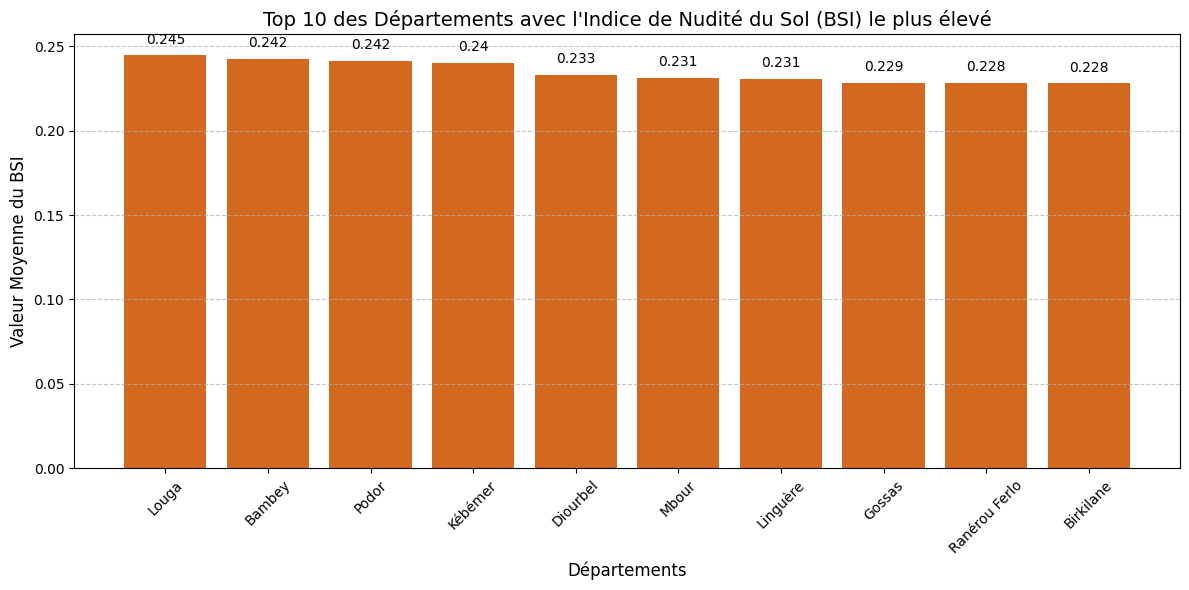

In [ ]:
import matplotlib.pyplot as plt
# Sélection du Top 10
top_10 = df_sorted.head(10)

# Création du graphique
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10['NAME_2'], top_10['mean'], color='chocolate')

# Personnalisation
plt.title('Top 10 des Départements avec l\'Indice de Nudité du Sol (BSI) le plus élevé', fontsize=14)
plt.xlabel('Départements', fontsize=12)
plt.ylabel('Valeur Moyenne du BSI', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter les valeurs au-dessus des barres pour la précision
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.show()

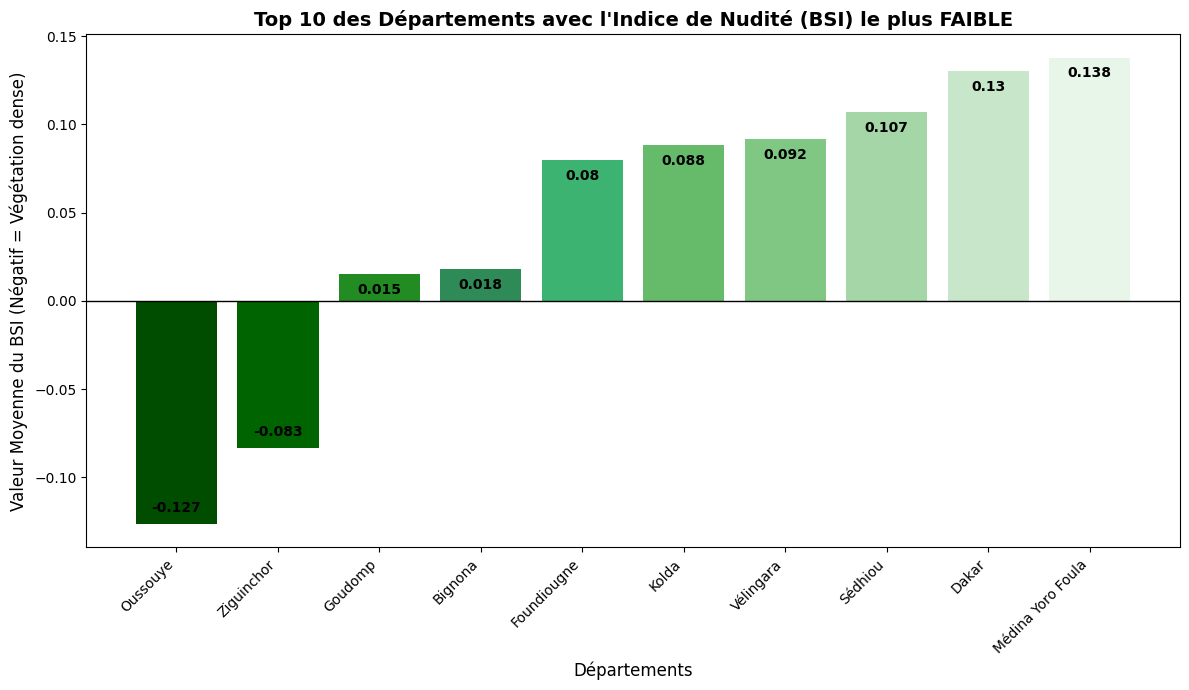

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# 1. Chargement et tri (du plus faible au plus élevé cette fois)
df = pd.read_csv('/content/drive/MyDrive/BSI_sans_eau_Senegal_2018.csv')
# On trie par ordre croissant pour avoir les plus petits (les plus verts) en premier
df_lowest = df.sort_values(by='mean', ascending=True).head(10).reset_index(drop=True)

# 2. Création du graphique
plt.figure(figsize=(12, 7))

# Palette de dégradé vert (du plus dense au moins dense)
green_palette = ['#004d00', '#006400', '#228B22', '#2E8B57', '#3CB371',
                 '#66BB6A', '#81C784', '#A5D6A7', '#C8E6C9', '#E8F5E9']

bars = plt.bar(df_lowest['NAME_2'], df_lowest['mean'], color=green_palette)

# 3. Habillage
plt.title('Top 10 des Départements avec l\'Indice de Nudité (BSI) le plus FAIBLE', fontsize=14, fontweight='bold')
plt.ylabel('Valeur Moyenne du BSI (Négatif = Végétation dense)', fontsize=12)
plt.xlabel('Départements', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Ajout d'une ligne horizontale à zéro pour bien voir les valeurs négatives
plt.axhline(0, color='black', linewidth=1)

# Ajouter les valeurs au bout des barres
for bar in bars:
    yval = bar.get_height()
    # On ajuste la position du texte selon si la valeur est positive ou négative
    va_pos = 'top' if yval > 0 else 'bottom'
    offset = -0.005 if yval > 0 else 0.005
    plt.text(bar.get_x() + bar.get_width()/2, yval + offset, round(yval, 3),
             va=va_pos, ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Charger les 3 bases

df_bsi = pd.read_csv('/content/drive/MyDrive/BSI_sans_eau_Senegal_2018.csv')



In [24]:
df_bsi.columns

Index(['NAME_1', 'NAME_2', 'mean', 'dep_key'], dtype='object')

In [9]:
df_welfare = pd.read_csv('/content/drive/MyDrive/ehcvm_welfare_SEN2018_TP6_SES_BAI_NDBI.csv')
df_individu = pd.read_csv('/content/drive/MyDrive/ehcvm_individu_SEN2018_TP6_SES_BAI_NDBI.csv')

In [11]:
df_individu

country  year  vague    hhid  grappe  menage  numind  zae      domaine  \
0         SEN  2018      1    1001       1       1       1    1  Capitale V1   
1         SEN  2018      1    1001       1       1       2    1  Capitale V1   
2         SEN  2018      1    1002       1       2       1    1  Capitale V1   
3         SEN  2018      1    1002       1       2       2    1  Capitale V1   
4         SEN  2018      1    1003       1       3       1    1  Capitale V1   
...       ...   ...    ...     ...     ...     ...     ...  ...          ...   
50090     SEN  2018      2  598012     598      12      11    5           11   
50091     SEN  2018      2  598012     598      12      12    5           11   
50092     SEN  2018      2  598012     598      12      13    5           11   
50093     SEN  2018      2  598012     598      12      14    5           11   
50094     SEN  2018      2  598012     598      12      15    5           11   

        region  ... sectins_sec csp_sec  volhor_sec salaire_sec bank  \
0        DAKAR  ...         NaN     NaN         NaN         NaN  Non   
1        DAKAR  ...         NaN     NaN         NaN         NaN  Non   
2        DAKAR  ...         NaN     NaN         NaN         NaN  Oui   
3        DAKAR  ...         NaN     NaN         NaN         NaN  Non   
4        DAKAR  ...         NaN     NaN         NaN         NaN  Oui   
...        ...  ...         ...     ...         ...         ...  ...   
50090  SEDHIOU  ...         NaN     NaN         NaN         NaN  Non   
50091  SEDHIOU  ...         NaN     NaN         NaN         NaN  Non   
50092  SEDHIOU  ...         NaN     NaN         NaN         NaN  Non   
50093  SEDHIOU  ...         NaN     NaN         NaN         NaN  Non   
50094  SEDHIOU  ...         NaN     NaN         NaN         NaN  Non   

       departement_norm NDVI_moyen      NDTI BAI_moyen NDBI_MOYEN  
0                 DAKAR   0.076941  0.019437   39.5313   0.069447  
1                 DAKAR   0.076941  0.019437   39.5313   0.069447  
2                 DAKAR   0.076941  0.019437   39.5313   0.069447  
3                 DAKAR   0.076941  0.019437   39.5313   0.069447  
4                 DAKAR   0.076941  0.019437   39.5313   0.069447  
...                 ...        ...       ...       ...        ...  
50090           GOUDOMP   0.498229  0.001424   30.6058  -0.091008  
50091           GOUDOMP   0.498229  0.001424   30.6058  -0.091008  
50092           GOUDOMP   0.498229  0.001424   30.6058  -0.091008  
50093           GOUDOMP   0.498229  0.001424   30.6058  -0.091008  
50094           GOUDOMP   0.498229  0.001424   30.6058  -0.091008  

[50095 rows x 56 columns]

In [12]:
# Fonction de nettoyage pour une jointure parfaite
def harmoniser_nom(nom):
    if isinstance(nom, str):
        import unicodedata
        # Passage en majuscules, retrait des accents et des espaces de début/fin
        nom = unicodedata.normalize('NFD', nom).encode('ascii', 'ignore').decode("utf-8")
        return nom.upper().strip().replace("-", " ").replace("_", " ")
    return nom



In [14]:
# Application de l'harmonisation
# On suppose que dans ton CSV BSI, la colonne est 'NAME_2'
df_bsi['dep_key'] = df_bsi['NAME_2'].apply(harmoniser_nom)

# Dans les bases EHCVM, on utilise 'departement' ou 'departement_norm'
df_welfare['dep_key'] = df_welfare['departement_norm'].apply(harmoniser_nom)
df_individu['dep_key'] = df_individu['departement_norm'].apply(harmoniser_nom)

In [15]:
# Sélectionner uniquement les colonnes nécessaires du BSI pour éviter les doublons
bsi_data = df_bsi[['dep_key', 'mean']].rename(columns={'mean': 'BSI_MEAN'})

# Merge avec la base Bien-être (Welfare)
df_welfare_final = pd.merge(df_welfare, bsi_data, on='dep_key', how='left')

# Merge avec la base Individus
df_individu_final = pd.merge(df_individu, bsi_data, on='dep_key', how='left')

# Vérification : Y a-t-il des départements non fusionnés ?
missing = df_welfare_final[df_welfare_final['BSI_MEAN'].isna()]['dep_key'].unique()
if len(missing) > 0:
    print(f"Attention, départements non trouvés : {missing}")
else:
    print("Fusion réussie pour tous les départements !")

Fusion réussie pour tous les départements !


In [22]:
print(df_welfare_final)

     country  year    hhid  grappe  menage  vague  zae   region  milieu  \
0        SEN  2018    1001       1       1      1    1    DAKAR  Urbain   
1        SEN  2018    1002       1       2      1    1    DAKAR  Urbain   
2        SEN  2018    1003       1       3      1    1    DAKAR  Urbain   
3        SEN  2018    2001       2       1      2    1    DAKAR  Urbain   
4        SEN  2018    2002       2       2      2    1    DAKAR  Urbain   
...      ...   ...     ...     ...     ...    ...  ...      ...     ...   
5400     SEN  2018  598008     598       8      2    5  SEDHIOU   Rural   
5401     SEN  2018  598009     598       9      2    5  SEDHIOU   Rural   
5402     SEN  2018  598010     598      10      2    5  SEDHIOU   Rural   
5403     SEN  2018  598011     598      11      2    5  SEDHIOU   Rural   
5404     SEN  2018  598012     598      12      2    5  SEDHIOU   Rural   

        hhweight  ...       zzae      zref   def_spa  def_temp  \
0     1749.83220  ...  391340.34 

In [17]:
# On supprime la clé temporaire 'key' pour garder les bases propres
df_welfare_final = df_welfare_final.drop(columns=['dep_key'])
df_individu_final = df_individu_final.drop(columns=['dep_key'])

In [19]:
df_welfare_final.to_csv('ehcvm_welfare_SEN2018_TP6_SES_with_BSI.csv', index=False)
df_individu_final.to_csv('ehcvm_individu_SEN2018_TP6_SES_with_BSI.csv', index=False)

In [23]:
import shutil

# Copie des fichiers du dossier temporaire vers la racine de ton Drive
shutil.copy('ehcvm_welfare_SEN2018_TP6_SES_with_BSI.csv', '/content/drive/MyDrive/ehcvm_welfare_SEN2018_TP6_SES_with_BSI.csv')
shutil.copy('ehcvm_individu_SEN2018_TP6_SES_with_BSI.csv', '/content/drive/MyDrive/ehcvm_individu_SEN2018_TP6_SES_with_BSI.csv')

print("Fichiers sauvegardés avec succès sur Google Drive.")

Fichiers sauvegardés avec succès sur Google Drive.


In [40]:


# 1. Simplification drastique pour l'affichage (1000m de précision suffit pour la carte)
# Cela évite que le navigateur ne plante avec trop de points géographiques
stats_pour_carte = stats_departements.map(lambda f: f.simplify(1000))

# 2. On ne garde que les colonnes indispensables pour alléger le transfert
stats_pour_carte = stats_pour_carte.select(['NAME_1', 'NAME_2', 'mean'])

# 3. Conversion vers GeoDataFrame (avec une sécurité)
try:
    print("Transfert des données vers la carte... (Patientez 15-30 sec)")
    gdf_local = geemap.ee_to_gdf(stats_pour_carte)
    print("✅ Transfert réussi !")
except Exception as e:
    print(f"Erreur de transfert : {e}. On va essayer avec moins de détails.")
    # Secours : simplification encore plus forte si ça échoue
    gdf_local = geemap.ee_to_gdf(stats_pour_carte.map(lambda f: f.simplify(5000)))

# 4. Création de la carte optimisée
Map = geemap.Map(center=[14.5, -14.5], zoom=7)

# Visualisation du BSI (on utilise une résolution plus basse pour l'affichage fluide)
vis_params = {'min': -0.1, 'max': 0.2, 'palette': ['#006400', '#FFFF00', '#8B4513']}
Map.addLayer(bsi_annual_mean.clip(departements), vis_params, 'BSI (Aperçu)')

# 5. Ajout de la couche interactive
Map.add_data(
    gdf_local,
    column='mean',
    layer_name='Statistiques BSI',
    style={'color': 'black', 'fillColor': '00000000', 'weight': 1},
    hover_style={'fillColor': '#228B22', 'fillOpacity': 0.5}
)

# 6. Configuration de l'infobulle (Hover)
from ipywidgets import HTML
from ipyleaflet import WidgetControl
output = HTML("Survolez un département")
Map.add_control(WidgetControl(widget=output, position='bottomright'))

def on_hover(feature, **kwargs):
    p = feature['properties']
    # On affiche les infos directement depuis l'objet local
    output.value = f"""
    <div style="background: white; padding: 5px; border: 1px solid black;">
        <b>Région:</b> {p.get('NAME_1')}<br>
        <b>Département:</b> {p.get('NAME_2')}<br>
        <b>BSI Moyen:</b> {p.get('mean'):.4f}
    </div>
    """

Map.layers[-1].on_hover(on_hover)
Map

Transfert des données vers la carte... (Patientez 15-30 sec)


KeyboardInterrupt: 

In [41]:
gdf_gadm = geemap.ee_to_gdf(departements)

# 3. JOINTURE LOCALE (Python pur - Ultra rapide)
# On fusionne tes chiffres CSV avec les formes GADM
# On utilise 'NAME_2' qui est présent dans les deux
gdf_final = gdf_gadm.merge(df_bsi[['NAME_2', 'NAME_1', 'mean']], on='NAME_2', how='left')

In [44]:
import numpy as np

# On crée manuellement l'alias que Geopandas recherche
if not hasattr(np, 'object0'):
    np.object0 = np.object_
    print("✅ Patch NumPy appliqué avec succès. Tu peux lancer la carte.")

✅ Patch NumPy appliqué avec succès. Tu peux lancer la carte.


In [45]:
# 4. CRÉATION DE LA CARTE
Map = geemap.Map(center=[14.5, -14.5], zoom=7)

# Image de fond (BSI calculé) - juste pour le visuel
vis_params = {'min': -0.1, 'max': 0.2, 'palette': ['#006400', '#FFFF00', '#8B4513']}
Map.addLayer(bsi_annual_mean.clip(departements), vis_params, 'Indice BSI (Pixels)')

# 5. AJOUT DES DONNÉES INTERACTIVES (Le CSV fusionné)
Map.add_data(
    gdf_final,
    column='mean',
    layer_name='Données EHCVM / BSI',
    style={'color': 'black', 'fillColor': '00000000', 'weight': 1},
    hover_style={'fillColor': '#228B22', 'fillOpacity': 0.4}
)

In [53]:
gdf_final.columns

Index(['geometry', 'CC_2', 'COUNTRY', 'ENGTYPE_2', 'GID_0', 'GID_1', 'GID_2',
       'HASC_2', 'NAME_1_x', 'NAME_2', 'NL_NAME_1', 'NL_NAME_2', 'TYPE_2',
       'VARNAME_2', 'NAME_1_y', 'mean', 'category', 'color'],
      dtype='object')

In [49]:
print(gdf_final[[ 'NAME_2', 'mean']].head())

        NAME_2      mean
0       Dagana  0.205700
1        Podor  0.241504
2  Saint-Louis  0.225154
3   Bounkiling  0.168830
4      Goudomp  0.015198


In [57]:
# Vérifie si la dernière couche ajoutée a bien les colonnes NAME_1_y
print("Colonnes disponibles dans la couche :", gdf_final.columns.tolist())

Colonnes disponibles dans la couche : ['geometry', 'CC_2', 'COUNTRY', 'ENGTYPE_2', 'GID_0', 'GID_1', 'GID_2', 'HASC_2', 'NAME_1_x', 'NAME_2', 'NL_NAME_1', 'NL_NAME_2', 'TYPE_2', 'VARNAME_2', 'NAME_1_y', 'mean', 'category', 'color']


In [61]:
# On calcule la moyenne de la colonne 'mean' de ton fichier final
moyenne_nationale = gdf_final['mean'].mean()
print(f"Moyenne Nationale BSI 2018 : {moyenne_nationale:.4f}")

Moyenne Nationale BSI 2018 : 0.1730


In [62]:
from ipywidgets import HTML
from ipyleaflet import WidgetControl, ZoomControl, LayersControl

# --- NETTOYAGE ---
if 'Map' in locals():
    Map.clear_controls()
    Map.add_control(ZoomControl())
    Map.add_control(LayersControl())

# --- 1. BANDEAU MOYENNE NATIONALE (Haut) ---
header_html = f"""
<div style="
    background-color: rgba(34, 139, 34, 0.9);
    color: white;
    padding: 10px 20px;
    border-radius: 20px;
    font-family: sans-serif;
    text-align: center;
    box-shadow: 0 4px 6px rgba(0,0,0,0.3);
    border: 2px solid white;
">
    <span style="font-size: 14px; text-transform: uppercase; letter-spacing: 1px;">Moyenne Nationale Sénégal 2018</span><br>
    <b style="font-size: 22px;">BSI : {moyenne_nationale:.4f}</b>
</div>
"""
header_widget = HTML(header_html)
Map.add_control(WidgetControl(widget=header_widget, position='topright'))

# --- 2. PANNEAU LATÉRAL DÉPARTEMENT (Bas Droite) ---
info_widget = HTML("""
<div style="background-color: white; padding: 12px; border: 2px solid #228B22; border-radius: 10px; font-family: sans-serif; min-width: 180px; box-shadow: 2px 2px 10px rgba(0,0,0,0.2);">
    <h3 style="margin: 0; color: #228B22; font-size: 15px;">Détails Locaux</h3>
    <p style="color: #666; font-size: 12px;">Survolez un département</p>
</div>
""")
Map.add_control(WidgetControl(widget=info_widget, position='bottomright'))

# --- 3. FONCTION DE SURVOL ---
def on_hover(feature, **kwargs):
    props = feature.get('properties', feature)
    dept = props.get('NAME_2', 'Inconnu')
    bsi = props.get('mean', 0)

    info_widget.value = f"""
    <div style="background-color: white; padding: 12px; border: 2px solid #228B22; border-radius: 10px; font-family: sans-serif; min-width: 180px;">
        <h4 style="margin: 0 0 8px 0; color: #228B22;">Département de {dept}</h4>
        <div style="background: #f9f9f9; padding: 8px; border-left: 4px solid #d35400;">
            <span style="font-size: 12px; color: #555;">BSI Local</span><br>
            <b style="font-size: 18px; color: #d35400;">{bsi:.4f}</b>
        </div>
    </div>
    """

# On lie à la couche (assure-toi que c'est bien la couche des polygones)
Map.layers[-1].on_hover(on_hover)

Map

Map(bottom=60901.0, center=[13.429695112188552, -13.127288818359375], controls=(ZoomControl(options=['position…

In [63]:
Map.save('/content/drive/MyDrive/Carte_BSI_Senegal_2018.html')